# Predicting US Job Market Trends Using Economic Indicators: A Study on Unemployment, GDP, and Inflation

In [2]:
! pip install pandas numpy matplotlib seaborn statsmodels scikit-learn

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv('USDataset.csv')

# Data Filtering: Filtering to ensure it covers the same time range
df['Date'] = pd.to_datetime(df['Date'])

# Filter the rows where place_id is 'USA'
df = df[df['place_id'] == 'USA']
df = df[df['frequency'] == 'monthly']

# Filter the relavant columns
relevant_columns = ['Date', 'place_id', 'yr', 'period', 'Gross domestic product, constant prices', 'Gross domestic product per capita, constant prices', 'Inflation, average consumer prices', 'Unemployment rate']
df = df[relevant_columns]
df.head()

# Set Date as index for time series analysis
df.set_index('Date', inplace=True)

# Data Normalization
columns_to_normalize = ['Unemployment rate', 'Gross domestic product, constant prices', 'Inflation, average consumer prices']
# Standardization (Z-score normalization)
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head()

,place_id,yr,period,"Gross domestic product, constant prices","Gross domestic product per capita, constant prices","Inflation, average consumer prices",Unemployment rate
Date,,,,,,,
1991-01-01,USA,1991,1,-1.391746,36944.07,1.130358,0.657181
1991-01-02,USA,1991,2,-1.391746,36944.07,1.130358,0.657181
1991-01-03,USA,1991,3,-1.391746,36944.07,1.130358,0.657181
1991-01-04,USA,1991,4,-1.391746,36944.07,1.130358,0.657181
1991-01-05,USA,1991,5,-1.391746,36944.07,1.130358,0.657181


## 2. Data Visualization

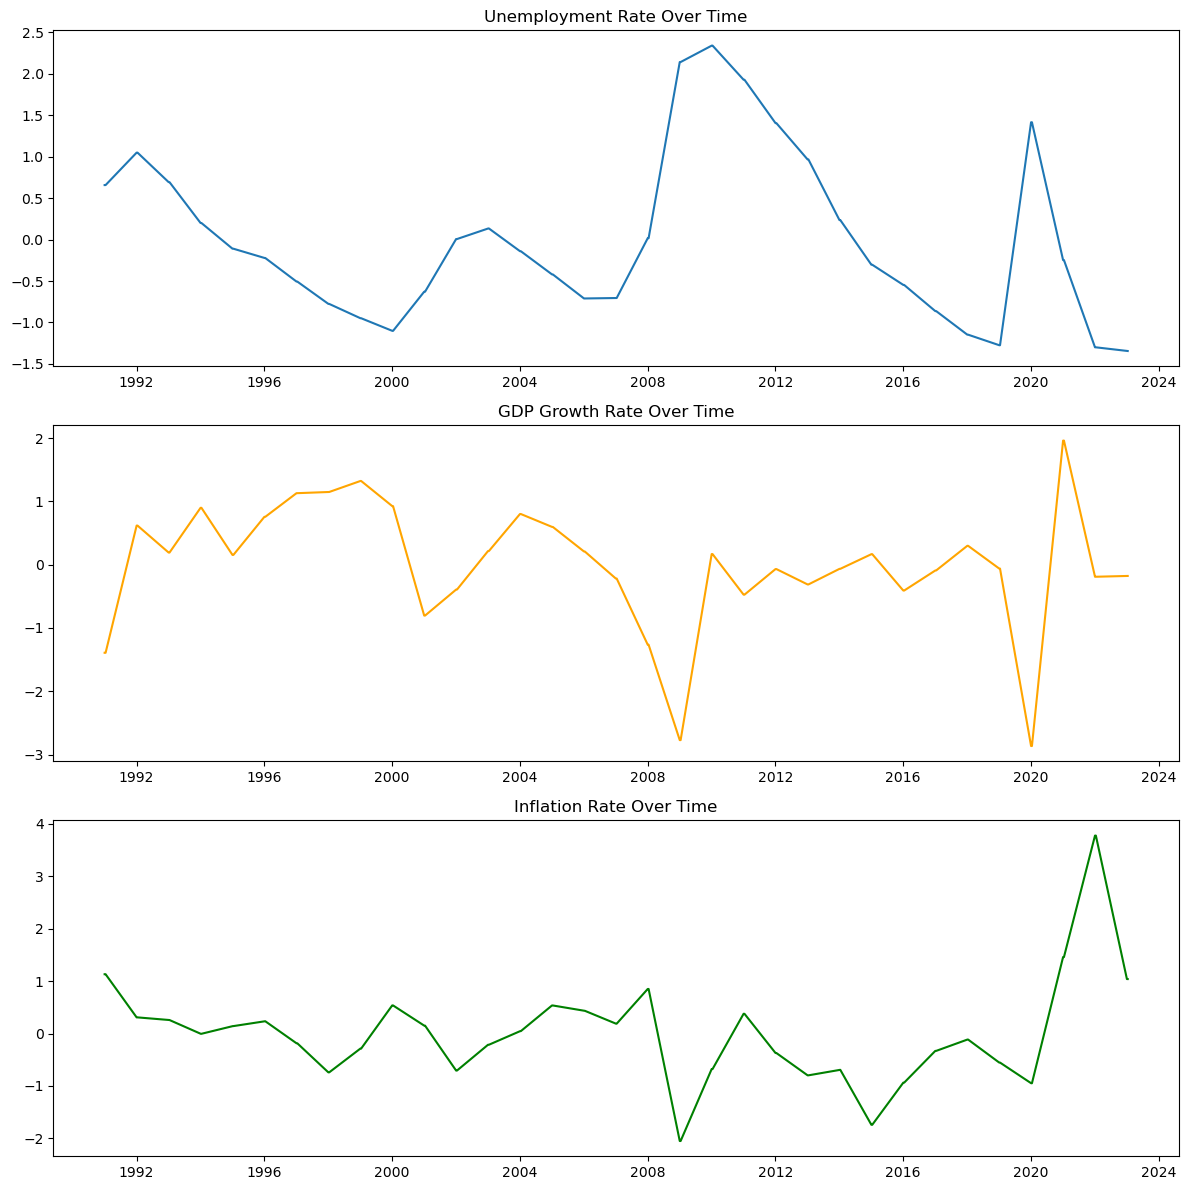

In [130]:
# Visualizing the data
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Unemployment rate'], label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')

plt.subplot(3, 1, 2)
plt.plot(df.index, df['Gross domestic product, constant prices'], label='GDP Growth Rate', color='orange')
plt.title('GDP Growth Rate Over Time')

plt.subplot(3, 1, 3)
plt.plot(df.index, df['Inflation, average consumer prices'], label='Inflation Rate', color='green')
plt.title('Inflation Rate Over Time')

plt.tight_layout()
plt.show()

### Relationships between parameters

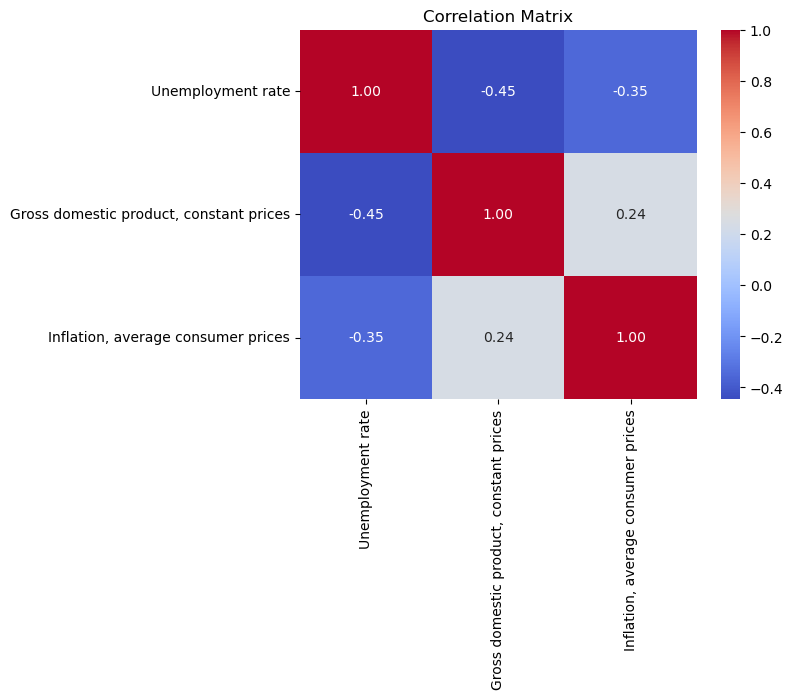

In [131]:
# Correlation matrix to check the relationships between variables
corr_matrix = df[['Unemployment rate', 'Gross domestic product, constant prices', 'Inflation, average consumer prices']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The correlations indicate the following relationships between the economic variables:

GDP and Unemployment Rate (-0.45): This negative correlation suggests that as GDP increases, the unemployment rate tends to decrease. This is generally consistent with the concept of an inverse relationship between economic growth (as measured by GDP) and unemployment. In other words, when the economy grows, more jobs are created, leading to lower unemployment.

GDP and Inflation Rate (0.24): This positive correlation indicates that as GDP increases, the inflation rate tends to rise, although the relationship is relatively weak. A positive correlation between GDP and inflation is often expected in the short run, as stronger economic growth can lead to higher demand for goods and services, which may push prices up.

Inflation Rate and Unemployment Rate (-0.35): The negative correlation here suggests that as the inflation rate increases, the unemployment rate tends to decrease. This could reflect a relationship where higher inflation might be associated with higher demand in the economy, potentially leading to lower unemployment. However, this relationship is also weak and may depend on the underlying economic context.

## 3. Model Training and Forecasting

### ARIMA Model (for time-series forecasting)

C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ac\anac

Root Mean Squared Error (RMSE) for ARIMA: 1.4641360813874806


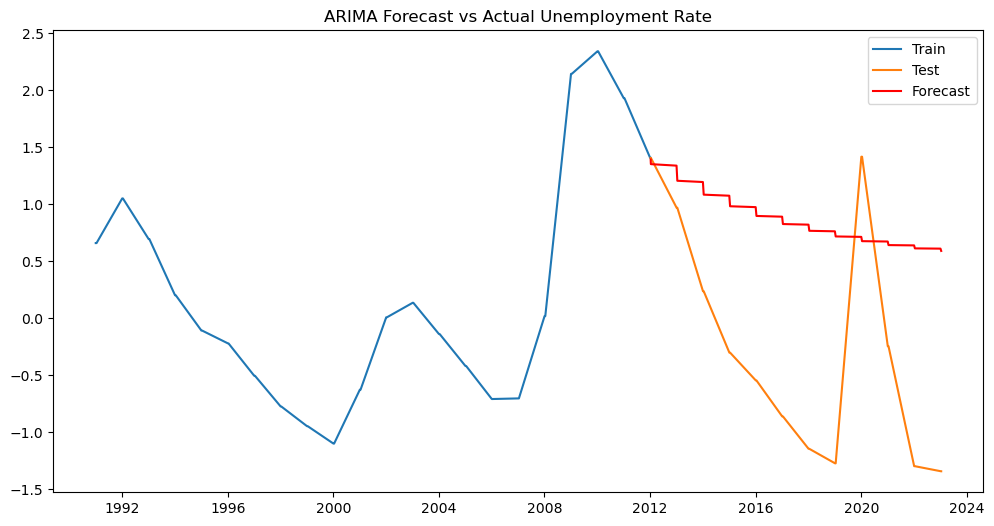

In [132]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Define the ARIMA model
unemployment_series = df['Unemployment rate']

# Train-test split (66-33 split)
train_size = int(len(unemployment_series) * 0.66)
train, test = unemployment_series[:train_size], unemployment_series[train_size:]

# Fit ARIMA model (p, d, q) where you can experiment with parameters
arima_model = ARIMA(train, order=(1, 0, 0))  # Example order, you may need to optimize
arima_fit = arima_model.fit()

# Forecasting
forecast = arima_fit.forecast(steps=len(test))

# Evaluate forecast accuracy
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'Root Mean Squared Error (RMSE) for ARIMA: {rmse}')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Unemployment Rate')
plt.legend()
plt.show()

### Linear Regression (GDP and Inflation to predict Unemployment)

Root Mean Squared Error (RMSE) for Linear Regression: 1.0681287042330334


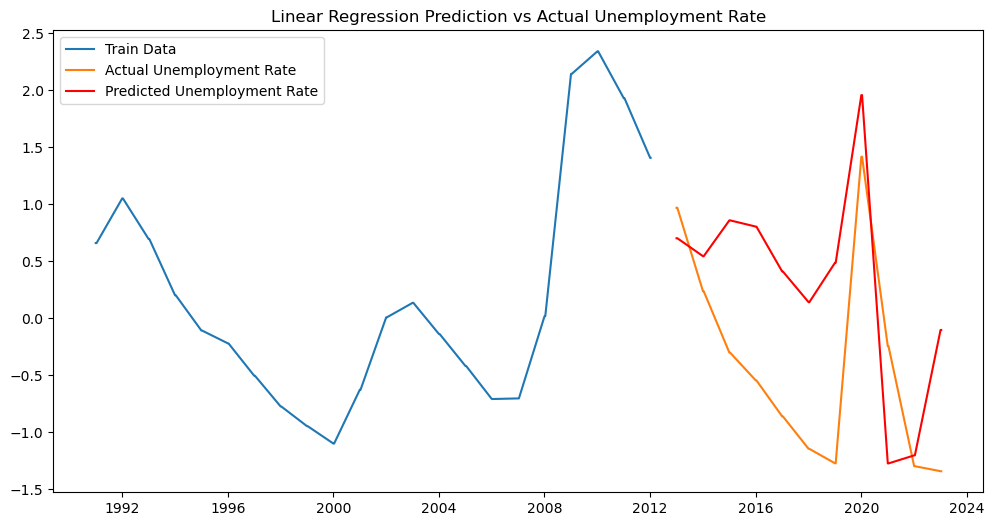

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the data for regression (predict unemployment using GDP and Inflation)
X = df[['Gross domestic product, constant prices', 'Inflation, average consumer prices']]  # Features
y = df['Unemployment rate']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Train a linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the regression model
reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) for Linear Regression: {reg_rmse}')

# Plot the predictions
plt.figure(figsize=(12, 6))
# Plot both the training and test data (optional)
plt.plot(train.index, train, label='Train Data')
#plt.plot(test.index, test, label='Test Data')

plt.plot(y_test.index, y_test, label='Actual Unemployment Rate')
plt.plot(y_test.index, y_pred, label='Predicted Unemployment Rate', color='red')
plt.title('Linear Regression Prediction vs Actual Unemployment Rate')
plt.legend()
plt.show()

##### The Root Mean Squared Error (RMSE) values for the ARIMA and Linear Regression models are as follows:
    ARIMA RMSE: 1.4641
    Linear Regression RMSE: 1.0681

Since the RMSE for the Linear Regression model (1.0681) is lower than that for the ARIMA model (1.4641), the Linear Regression model performs better in terms of accuracy for this particular dataset. The smaller RMSE suggests that Linear Regression's predictions are closer to the actual observed values compared to ARIMA.

Other Considerations :

While GDP, unemployment, and inflation are crucial indicators, other factors—such as technological advancements, labor force participation rates, government policies, and global economic trends—also play significant roles in shaping the U.S. job market. For instance:

    Technological Innovation: Automation and AI could change the types of jobs available, even during periods of economic growth.
    Labor Force Participation: A declining participation rate (e.g., due to aging populations) can also influence the availability of workers and the overall unemployment rate.

Conclusion
    
    By analyzing economic indicators such as GDP, inflation, and unemployment, we can gain valuable insights into future trends in the U.S. job market. These indicators often work in tandem, with each influencing the others. A strong and growing economy typically leads to job creation, while a slowing economy or inflationary pressures can create job losses. Understanding the relationships between these indicators is key to predicting employment trends and making informed decisions about workforce planning, government policy, and investment strategies.